# Single image star-galaxy classification using SVMs

> Alexandre Boucaud <aboucaud@lal.in2p3.fr>

This tutorial is about finding boundaries in a dataset with two classes using `scikit-learn` and SVMs. The dataset in question is a source catalog obtained by running [SExtractor](https://www.astromatic.net/software/sextractor) on a simulated deep field in the visible range seen from space instrument (sharp PSF). This catalog has been cross-matched with the initial catalog of the simulation to obtain the true class of the object `star` or `galaxy`.

_Disclaimer: this simulated data is not realistic (and not meant to be). It was used to test the impact of stellar spectra on the PSF width for a [Euclid](https://www.euclid-ec.org)-like mission_

Topics of interest covered:
- [preprocessing](#Preprocessing)
- [visualization](#Visualization)
- [training with different kernels](#Training)
- [hyperparameter search](#Hyperparameter-search)

### General imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

plt.style.use('ggplot')
cmap = plt.cm.Paired_r

### Loading the raw data

In [2]:
catalog_file = '../data/star_gal_catalog.fits'

# Load the SExtractor catalog
catalog = fits.getdata(catalog_file, ext=2)

# Load the cross-matched true object class
#   0 for unidentified objects
#   1 for stars
#   2 for galaxies
object_class = fits.getdata(catalog_file, ext=3)['OBJCLASS']

## Preprocessing

Raw data cannot usually be used straight with ML models, it requires some _preprocessing_.

By _proprocessing_, we include 
- discarding some of the data
- generating some new features (here columns) out of your data
- normalizing the data (not always necessary)
- putting the data in a matrix that can be fed to the algorithms

Let's start with the labels.

### Labels

In [3]:
for val in np.unique(object_class):
    print(f'{val}: ', np.sum(object_class == val))

0:  100
1:  1700
2:  79963


First let's remove (for the purpose of this analysis) the 

In [4]:
cut = object_class != 0
catalog = catalog[cut]
object_class = object_class[cut]

Here the labels already have an encoding (0, 1, 2) but they could be strings ('star', 'galaxy', 'other'). 

In any case, it is important know how to encode them properly.
The `LabelEncoder` method is made for this.

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
lenc = LabelEncoder()
y = lenc.fit_transform(object_class)

In [7]:
for i in range(10):
    print(f'original: {object_class[i]}\tencoded: {y[i]}')

original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 1	encoded: 0
original: 2	encoded: 1


So now `0` stands for a star and `1` for a galaxy.

To recover the original values from encoded ones, the label encoder has a method: `lenc.inverse_transform()`.

### Data

The preprocessing of the data is deeply tied to the knowledge of the data + knowledge of the scientific domain.

To keep it short and simplify the processing for the tutorial, let's assume (valid to a certain extent) that one can classify stars vs. galaxies using the "mu_max / mag_auto" plane.

- **`mu_max`** is the value of the pixel of maximum brightness for the object
- **`mag_auto`** is a mesure of the magnitude (logarithm of the flux) of the object

In [8]:
mumax = catalog['MU_MAX']
mag = catalog['MAG_AUTO']

Let's also create this hybrid feature (explanation below)

In [9]:
mumag = mumax - mag

And let's create a data vector of shape (n_entries, n_features) with these two

In [10]:
# To concatenate two 1d array into a 2d array, their shape need to be expanded
# use either
# arr = arr[:, None]
# arr = arr[:, np.newaxis]
# arr = np.expand_dims(arr, axis=-1)

X = np.concatenate([mag[:, None], mumag[:, None]], axis=1)

In [11]:
X.shape

(81663, 2)

## Visualization

Stars beeing small unresolved sources, most of their flux is concentrated in a single  pixel (mu_max). That creates a natural correlation between `mu_max` and `mag_auto`. 

Let's display this correlation.

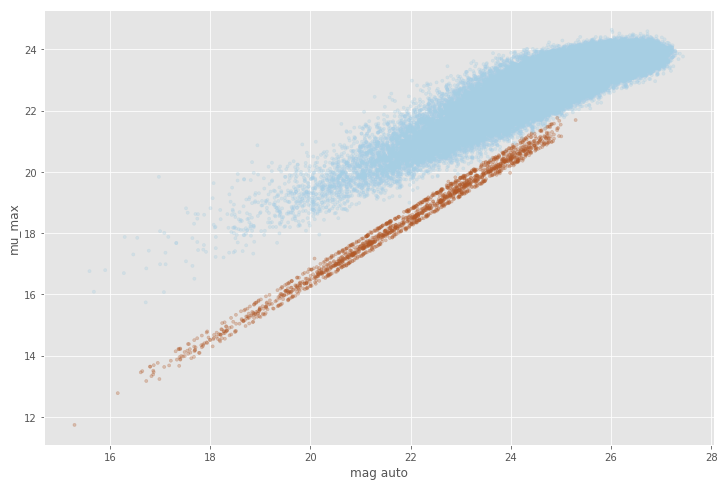

In [12]:
plt.figure(figsize=(12, 8))
# Use scatter when plotting a high number of individual points.
plt.scatter(mag, mumax,
            c=y,       # c=<label_array> will set one color per label in the array
            s=10,      # s=<int> will set the size of the dots
            alpha=0.3, # alpha=<float> will change the transparency of the dots
            cmap=cmap) 
plt.xlabel("mag auto")
plt.ylabel("mu_max");

For this reason, a common way of representing the data is the '`mu_max` - `mag_auto`' vs '`mag_auto`' plane so the stars "line up" given their magnitude.

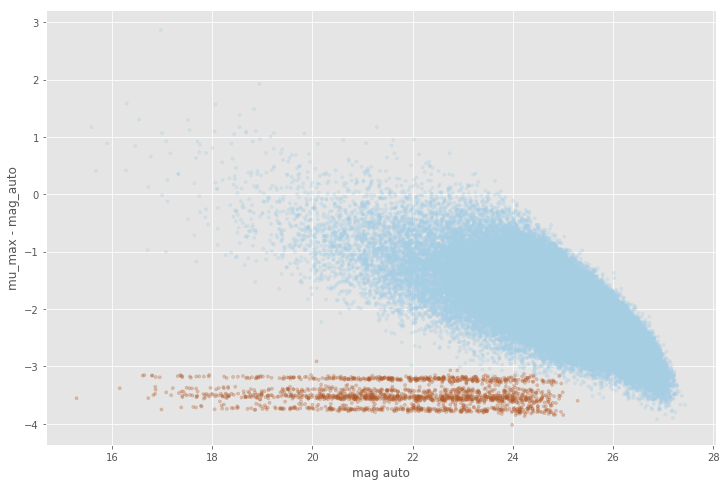

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(mag, mumax - mag,
            c=y,       
            s=10,      
            alpha=0.3, 
            cmap=cmap) 
plt.xlabel("mag auto")
plt.ylabel("mu_max - mag_auto");

## Training

We will use [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/svm.html#svm) and especially the Support Vector Classifier (SVC) of `scikit-learn` for the task. 

In [14]:
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

SVMs use various types of [kernels](http://scikit-learn.org/stable/modules/svm.html#kernel-functions) for their decision function, the most used being:
- **`linear`** for a linear model
- **`poly`** for a polynomial boundary decision
- **`rbf`** that stands for radial basis function (default kernel)

The decision function of a SVM relies on finding important data points close to the boundary, called ***support vectors***.

Let's try different kernels on the star-galaxy data by wrapping a visualization around.

In [15]:
def plot_svm_contours(kernel, X, y, bounds=[14.5, 28, -5, 3.5], **kwargs):
    clf = SVC(kernel=kernel, **kwargs)
    
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    # Fit the model on the data
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred, 
                                target_names=['stars', 'galaxies']))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'True positives: {tp} = galaxies classified as galaxies')
    print(f'False positives: {fp} = stars classified as galaxies')
    print(f'True negatives: {tn} = stars classified as stars')
    print(f'False negatives: {fn} = galaxies classified as stars')
    
    # Create an array of points to plot the decision regions
    x_min, x_max, y_min, y_max = bounds
    rows, cols = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    # Apply the decision function on the two vectors
    values = clf.decision_function(np.c_[rows.ravel(), cols.ravel()])
    # Reshape the array to recover the squared shape
    values = values.reshape(rows.shape)
    
    mag, mumag = X.T
    vect_x, vect_y = clf.support_vectors_.T

    plt.figure(figsize=(12, 8))
    
    # Plot data points
    plt.scatter(mag, mumag, c=y, 
                s=10, edgecolor='k',
                alpha=0.5,
                zorder=10, cmap=cmap)
    
    # Plot decision region
    plt.pcolormesh(rows, cols, values > 0, 
                   cmap=cmap)
    
    # Plot decision boundary
    plt.contour(rows, cols, values, 
                levels=[-.5, 0, .5],
                colors=['k', 'k', 'k'], 
                linestyles=['--', '-', '--'])
    
    # Plot support vectors
    plt.scatter(vect_x, vect_y, edgecolor='k',
                s=80, facecolors='none', zorder=10)
    
    plt.xlim(x_min + 0.5, x_max - 0.5)
    plt.ylim(y_min + 0.5, y_max - 0.5)
    plt.xlabel("mag auto")
    plt.ylabel("mu_max - mag_auto")

### Linear boundary

             precision    recall  f1-score   support

      stars       1.00      0.99      0.99       424
   galaxies       1.00      1.00      1.00     19992

avg / total       1.00      1.00      1.00     20416

True positives: 19990 = galaxies classified as galaxies
False positives: 6 = stars classified as galaxies
True negatives: 418 = stars classified as stars
False negatives: 2 = galaxies classified as stars


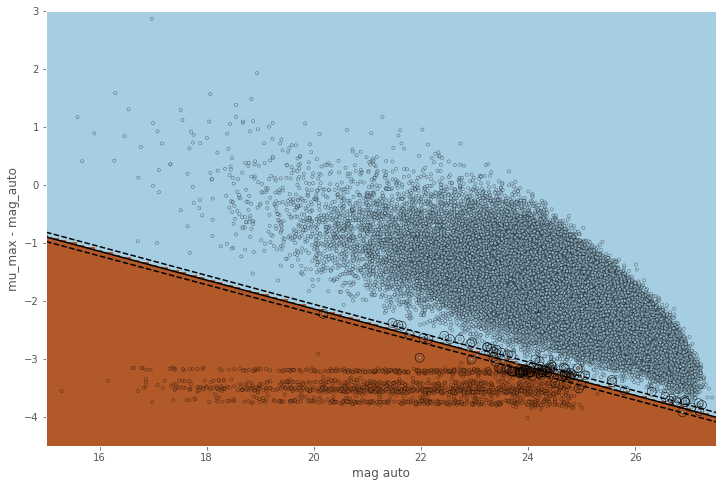

In [16]:
plot_svm_contours('linear', X, y)

### Polynomial

             precision    recall  f1-score   support

      stars       0.99      0.99      0.99       424
   galaxies       1.00      1.00      1.00     19992

avg / total       1.00      1.00      1.00     20416

True positives: 19987 = galaxies classified as galaxies
False positives: 4 = stars classified as galaxies
True negatives: 420 = stars classified as stars
False negatives: 5 = galaxies classified as stars


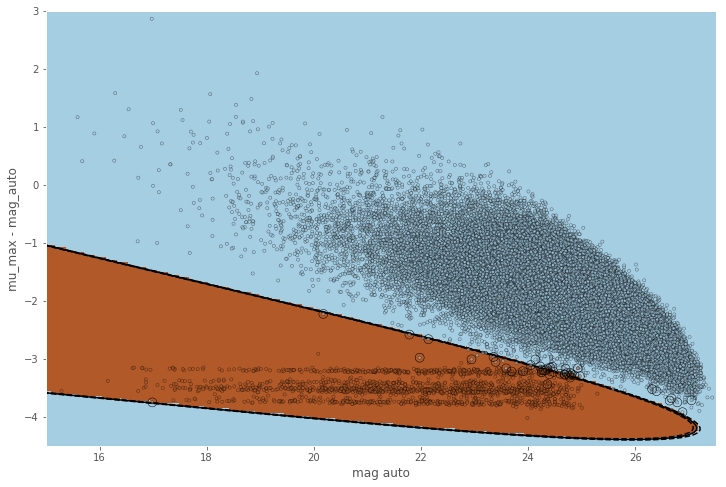

In [17]:
plot_svm_contours('poly', X, y)

### RBF

             precision    recall  f1-score   support

      stars       0.99      1.00      0.99       424
   galaxies       1.00      1.00      1.00     19992

avg / total       1.00      1.00      1.00     20416

True positives: 19988 = galaxies classified as galaxies
False positives: 1 = stars classified as galaxies
True negatives: 423 = stars classified as stars
False negatives: 4 = galaxies classified as stars


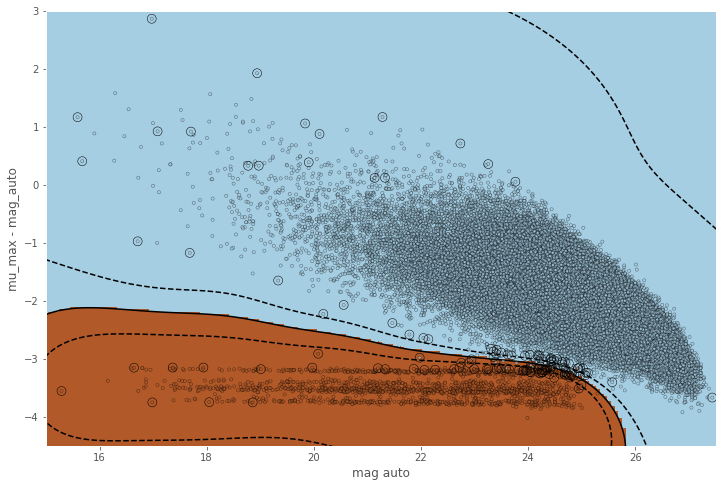

In [18]:
plot_svm_contours('rbf', X, y)

## Hyperparameter search

Radial basis functions are parameterized by **`C`** and **`gamma`** (see [doc](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py)), which adds a degree of freedom when looking for the optimal hyper-parameters.

Fortunately a library like scikit-learn has an implemented hyper-parameter optimization (a.k.a. hyperopt) method : `GridSearchCV`.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

Start by defining the parameter space (values) you'd like to explore. Using logarithmic grid at first is a good idea.

In [20]:
parameters_grid = { 
    'C':[0.01, 0.1, 1, 10, 100, 1000], 
    'gamma':[0.001, 0.01, 0.1, 1, 10, 100]
    }

Add a cross-validation scheme so the data is randomized and scored over various folds to ensure a more accurate score.

In [21]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

Then give `GridSearchCV` the ML model and the grid of its hyperparameters and fit it on the data.

In [25]:
# Parallelize the process by using several cores with `n_jobs`.
clf = GridSearchCV(SVC('rbf'), 
                   param_grid=parameters_grid, 
                   cv=cv,      # cross-validation scheme
                   n_jobs=-1)  # n_jobs=-1 means 'use all available cores' 

clf.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C='rbf', cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

After such evaluation **(which may take time)**, the model `clf` will contain a dictionary of the optimal hyperparameters and the related score

In [26]:
print(f'The optimal params are {clf.best_params_} that gave a score of {clf.best_score_:0.5f}')

The optimal params are {'C': 100, 'gamma': 0.1} that gave a score of 0.99993


Which can be used to plot the "best" decision boundary

             precision    recall  f1-score   support

      stars       1.00      1.00      1.00       424
   galaxies       1.00      1.00      1.00     19992

avg / total       1.00      1.00      1.00     20416

True positives: 19990 = galaxies classified as galaxies
False positives: 0 = stars classified as galaxies
True negatives: 424 = stars classified as stars
False negatives: 2 = galaxies classified as stars


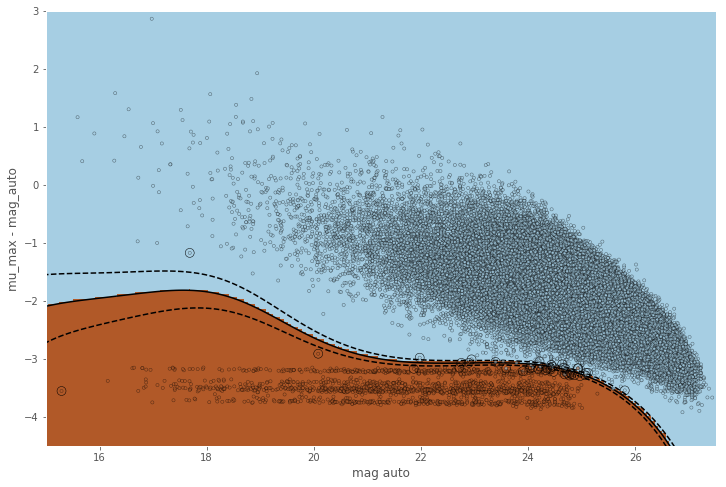

In [27]:
plot_svm_contours('rbf', X, y, **clf.best_params_)

One idea could then be to refine the search using a linear grid around the best parameters of the logarithmic grid.